# Tutorial: Quantifying allele-specific expression 

This is the second tutorial based on *De novo and inherited loss-of-function
variants in TLK2: identification, clinical delineation and
genotype-phenotype evaluation of a distinct neurodevelopmental disorder*
by MRF Reijnders, KA Miller et al and in particular Figure 4 from that paper.

Here, we will discuss how amplimap was used to quantify allele-specific expression
of two loss-of-function mutations found in patients, and thus measure their effect
on nonsense-mediated decay (NMD).

We will be using a subset of the samples, looking at a single replicate from two different mutations, both of which generate a premature stop codon:

- p.Ser330\*, which is expected to result in a truncated product leading to NMD
- p.Arg698\*, which is expected to escape NMD because it is located in the last exon

For both of these mutations, we will look at the balance between the mutation allele and the wild-type allele.
If no NMD occured, both the wild-type and the mutation allele should be observed in 50% of the reads. If
one of the alleles was targeted for NMD, we should be seeing an inbalance in the read counts.

## Analysis overview

Starting from the raw sequencing reads, we would like to:

-  Trim off primer sequences
-  Align reads to the reference genome, taking into account gaps introduced by spliced introns
-  Count how often each allele was observed at the mutation site 

## Initial setup

To run this tutorial amplimap needs to be installed and configured already.
Please see [Installation](https://amplimap.readthedocs.io/en/latest/installation.html)
and [Configuration](https://amplimap.readthedocs.io/en/latest/configuration.html) for details.

In particular, you need to have the hg19 (GRCh37) reference FASTA genome and the
associated indices prepared for use with STAR (see [Reference genome paths](https://amplimap.readthedocs.io/en/latest/configuration.html#reference-genome-paths)).

## Preparing the working directory


For every experiment that we want to process, we create a new working
directory. This will contain all the input files required, as well as
the output generated by amplimap. This makes it easy to keep track of
the data for each experiment, as well as to rerun analyses if required.

To create a directory, we use the standard ``mkdir`` unix command and
change into it with ``cd``:

    mkdir TLK2_NMD
    cd TLK2_NMD

All further commands should now be run inside this working directory.

### reads_in

The first input we need to provide to amplimap is of course the
sequencing data. These can be obtained directly from the sequencer as
``.fastq.gz`` files and should be placed in a directory called [``reads_in``](https://amplimap.readthedocs.io/en/latest/usage.html#reads-in).

[Download the sample data from this tutorial](http://userweb.molbiol.ox.ac.uk/public/koelling/amplimap/tutorial_data/TLK2_ASE.tar)
and extract the ``reads_in`` directory into your working directory.

You can use ``ls`` to check that the files are there:

    ls reads_in

This should display a list of four fastq.gz files, which represent read 1
and read 2 of two samples:

    Sample1_Ser330_L001_R1_001.fastq.gz
    Sample1_Ser330_L001_R2_001.fastq.gz
    Sample2_Arg698_L001_R1_001.fastq.gz
    Sample2_Arg698_L001_R2_001.fastq.gz


### probes.csv

Next, we need to provide a [probes.csv file](https://amplimap.readthedocs.io/en/latest/usage.html#probes-csv) that describes the used
primer sequences and the regions they are supposed to capture. This can
be created with spreadsheet software such as Excel, as long as the file is
saved as plain text. However, we recommend always checking the file manually
using a plain text editor such as ``nano`` or ``vim``, to make sure it is actually in the right
format.

Create a new plain text file called ``probes.csv`` (for example using ``nano``
or ``vim``) in your working directory and copy the following text into it:

    id,first_primer_5to3,second_primer_5to3,chr,target_start,target_end,strand
    TLK2_cDNA_1,TGCAAGACCGCTTGAGACTG,CAGCTCTGCCTGGATCTCTG,chr17,60642418,60655843,+
    TLK2_cDNA_2,GCATGCATGTAGGGAATACCG,ACTGTTATTGGACGCCCCAG,chr17,60673966,60689893,+

### snps.txt

In this case we have two specific genomic positions that we want to look at and
also know the alleles that we expect to see. Thus, we can provide a
[snps.txt](https://amplimap.readthedocs.io/en/latest/usage.html#snps-txt) file
and obtain allele counts specifically for these positions, rather than
screening a whole genomic region. This both speeds up the processing
and simplifies the downstream analysis.

Create a new plain text file called ``snps.txt`` (for example using ``nano``
or ``vim``) in your working directory and copy the following text into it:

    chr17	60650596	TLK2_Ser330	C	A
    chr17	60689765	TLK2_Arg698	C	T

### config.yaml

Finally, we create a config.yaml file to set some experiment-specific settings.
We could set [a lot more options](https://amplimap.readthedocs.io/en/latest/configuration.html)
here but in this case set a few of them. All the other options will be left at
the as specified in the default configuration.

Create a new plain text file called ``config.yaml`` (for example using ``nano``
or ``vim``) in your working directory and copy the following text into it:

    general:
      genome_name: "hg19"
    align:
      aligner: "star"

This tells amplimap to run using the reference genome hg19, as specified in your
[default configuration](https://amplimap.readthedocs.io/en/latest/configuration.html#default-configuration).
If you do not have this reference genome set up there, you can also specify the necessary paths directly
in the ``config.yaml``, by adding the following additional lines and editing the paths to match your local setup:

    paths:
      hg19:
        star: "/INSERT/PATH/TO/GENOME"
        fasta: "/INSERT/PATH/TO/FASTA"
        annotation_gff: "/INSERT/PATH/TO/ANNOTATION_GFF"

Note that we also specify the **STAR aligner** instead of the normal option of BWA/bowtie2. This is because
we are dealing with spliced cDNA here, which means that our
reads will only contain the exonic sequence. We need to use an aligner that work with spliced data
and create alignments with long gaps to account for introns.

For a real-world analysis, we might also want to use a custom reference genome in which we have masked the target SNPs to avoid reference bias. However, for the purposes of this example, we will stick with the standard reference.

## Running amplimap

Now we can run amplimap. In our case, we want to obtain coverage values
(“coverages”) and annotated variant calls (“variants”). This will also
automatically run the other parts of the pipeline that are required,
such as trimming the primers and aligning reads to the genome.
First we will do a dry-run to confirm that all input files can be found:

    amplimap pileups
    
This should output a long list of commands, ending with these lines:

    Job counts:
        count   jobs
        2       align_pe
        1       copy_probes
        1       copy_snps
        2       do_pileup_snps
        4       link_reads
        2       parse_reads_pe
        1       pileup_snps_agg
        1       pileups
        1       start_analysis
        2       stats_alignment
        1       stats_alignment_agg
        1       stats_reads_agg
        1       stats_samples_agg
        20
    amplimap dry run successful. Set --run to run!


You can see how amplimap is planning to run 2 alignment jobs (align_pe) and 2 SNP pileup jobs (do_pileup_snps),
corresponding to the 2 samples we are analysing.

Having confirmed that everything looks as expected, we can run amplimap:

    amplimap pileups --run

This will take a few minutes to complete. It would be much faster if we
ran jobs in parallel (for example using a cluster), but we are not
doing that for the purposes of this tutorial.

## Analysing the results

amplimap has now processed our reads, aligned them to the reference genome, called germline variants, annotated them
and produced a summary table with the variant calls.
All of the output files have been placed into the ``analysis`` directory.

Let's explore some of the output.  In this tutorial, we will use Python and pandas for this, but the same thing could be done in R, or by just looking at the tables in Excel.

### analysis/reads_parsed/

This directory contains results from the first step of the pipeline which
identified primer arms in reads, trimmed them off and calculated some
run statistics.

For example, the ``stats_samples.csv`` file tells us about the number of reads in each sample and how many of these contained the expected primer sequences:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

pd.read_csv('analysis/reads_parsed/stats_samples.csv')

,sample,files,pairs_total,pairs_unknown_arms,pairs_good_arms,pairs_r1_too_short,pairs_r2_too_short
0,Sample1_Ser330,1,6157,362,5795,0,0
1,Sample2_Arg698,1,477,26,451,0,0


And for a more detailed look at the number of reads observed per probe in each sample, there is ``stats_reads.csv``:

In [2]:
pd.read_csv('analysis/reads_parsed/stats_reads.csv')

,sample,probe,read_pairs
0,Sample1_Ser330,TLK2_cDNA_1,5795
1,Sample2_Arg698,TLK2_cDNA_2,451


We can see that Sample 1 had a lot more reads than Sample 2, but both of them have good coverage. As expected, Sample 1 only contained reads for the first probe targeting Ser330, while Sample 2 only contained reads for the second probe targeting Arg698.

### analysis/pileup_snps/

Based on the details that we provided in ``snps.txt``, amplimap has generated pileup tables that contains the read counts for each of the alleles at each of the SNPs.

Let's have a look at the detailed summary table, which tells us the count for each possible nucleotide at each position and each sample:

In [3]:
d = pd.read_csv('analysis/pileup_snps/target_snps_pileups_long_detailed.csv')
d = d.loc[d.number_called_hq > 0].sort_values(['pos', 'sample'])
d[ ['sample', 'chr', 'pos', 'snp_ref', 'snp_alt', 'number_called_hq', 'snp_alt_hq_count_fraction', 'count_hq_A', 'count_hq_C', 'count_hq_G', 'count_hq_T'] ]

,sample,chr,pos,snp_ref,snp_alt,number_called_hq,snp_alt_hq_count_fraction,count_hq_A,count_hq_C,count_hq_G,count_hq_T
0,Sample1_Ser330,chr17,60650596,C,A,5238,0.212486,1113,3999,2,3
3,Sample2_Arg698,chr17,60689765,C,T,357,0.509804,0,175,0,182


To test whether the alt allele fraction differs significantly from the null expectation of 50% (ie. the fraction we would expect if there was no NMD), we can use a binomial test:

In [4]:
d['count_hq_alt'] = [getattr(row, 'count_hq_%s' % row.snp_alt) for row in d.itertuples()]
d['p_binom'] = [scipy.stats.binom_test(x = row.count_hq_alt, n = row.number_called_hq, p = 0.5) for row in d.itertuples()]

d[ ['sample', 'chr', 'pos', 'snp_ref', 'snp_alt', 'number_called_hq', 'count_hq_alt', 'snp_alt_hq_count_fraction', 'p_binom'] ]

,sample,chr,pos,snp_ref,snp_alt,number_called_hq,count_hq_alt,snp_alt_hq_count_fraction,p_binom
0,Sample1_Ser330,chr17,60650596,C,A,5238,1113,0.212486,4.940656e-324
3,Sample2_Arg698,chr17,60689765,C,T,357,182,0.509804,7.508743e-01


For Sample 1, we observed 5238 cDNA reads covering the Ser330\* mutation site. Of these, 1113 (21%) carried the nucleotide creating the mutation, while 3999 carried the reference nucleotide. This deviation from a balanced 50%/50% allele frequency ratio is highly significant $(p < 10^{-323})$ and suggests that mRNA carrying the mutation is degraded through nonsense-mediated decay, as expected.

On the other hand, we did not see a similar effect for the second mutation, which we expected to escape NMD. Here, the allele counts are roughly equal, with 51% of reads carrying the mutation $(p = 0.75)$.

We can also visualise this with a bar plot:

Text(0,0.5,'')

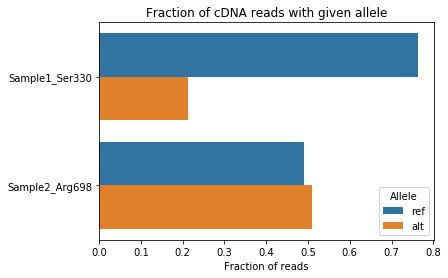

In [5]:
sns.barplot(
    data=d[ ['sample', 'snp_ref_hq_count_fraction', 'snp_alt_hq_count_fraction'] ] \
        .rename(columns = { 'snp_ref_hq_count_fraction': 'ref',  'snp_alt_hq_count_fraction': 'alt' }) \
        .melt(id_vars = ['sample'], var_name = 'Allele', value_name = 'fraction'),
    x='fraction',
    y='sample',
    hue='Allele',
    orient='h',
)
plt.title("Fraction of cDNA reads with given allele")
plt.xlabel("Fraction of reads")
plt.ylabel("")

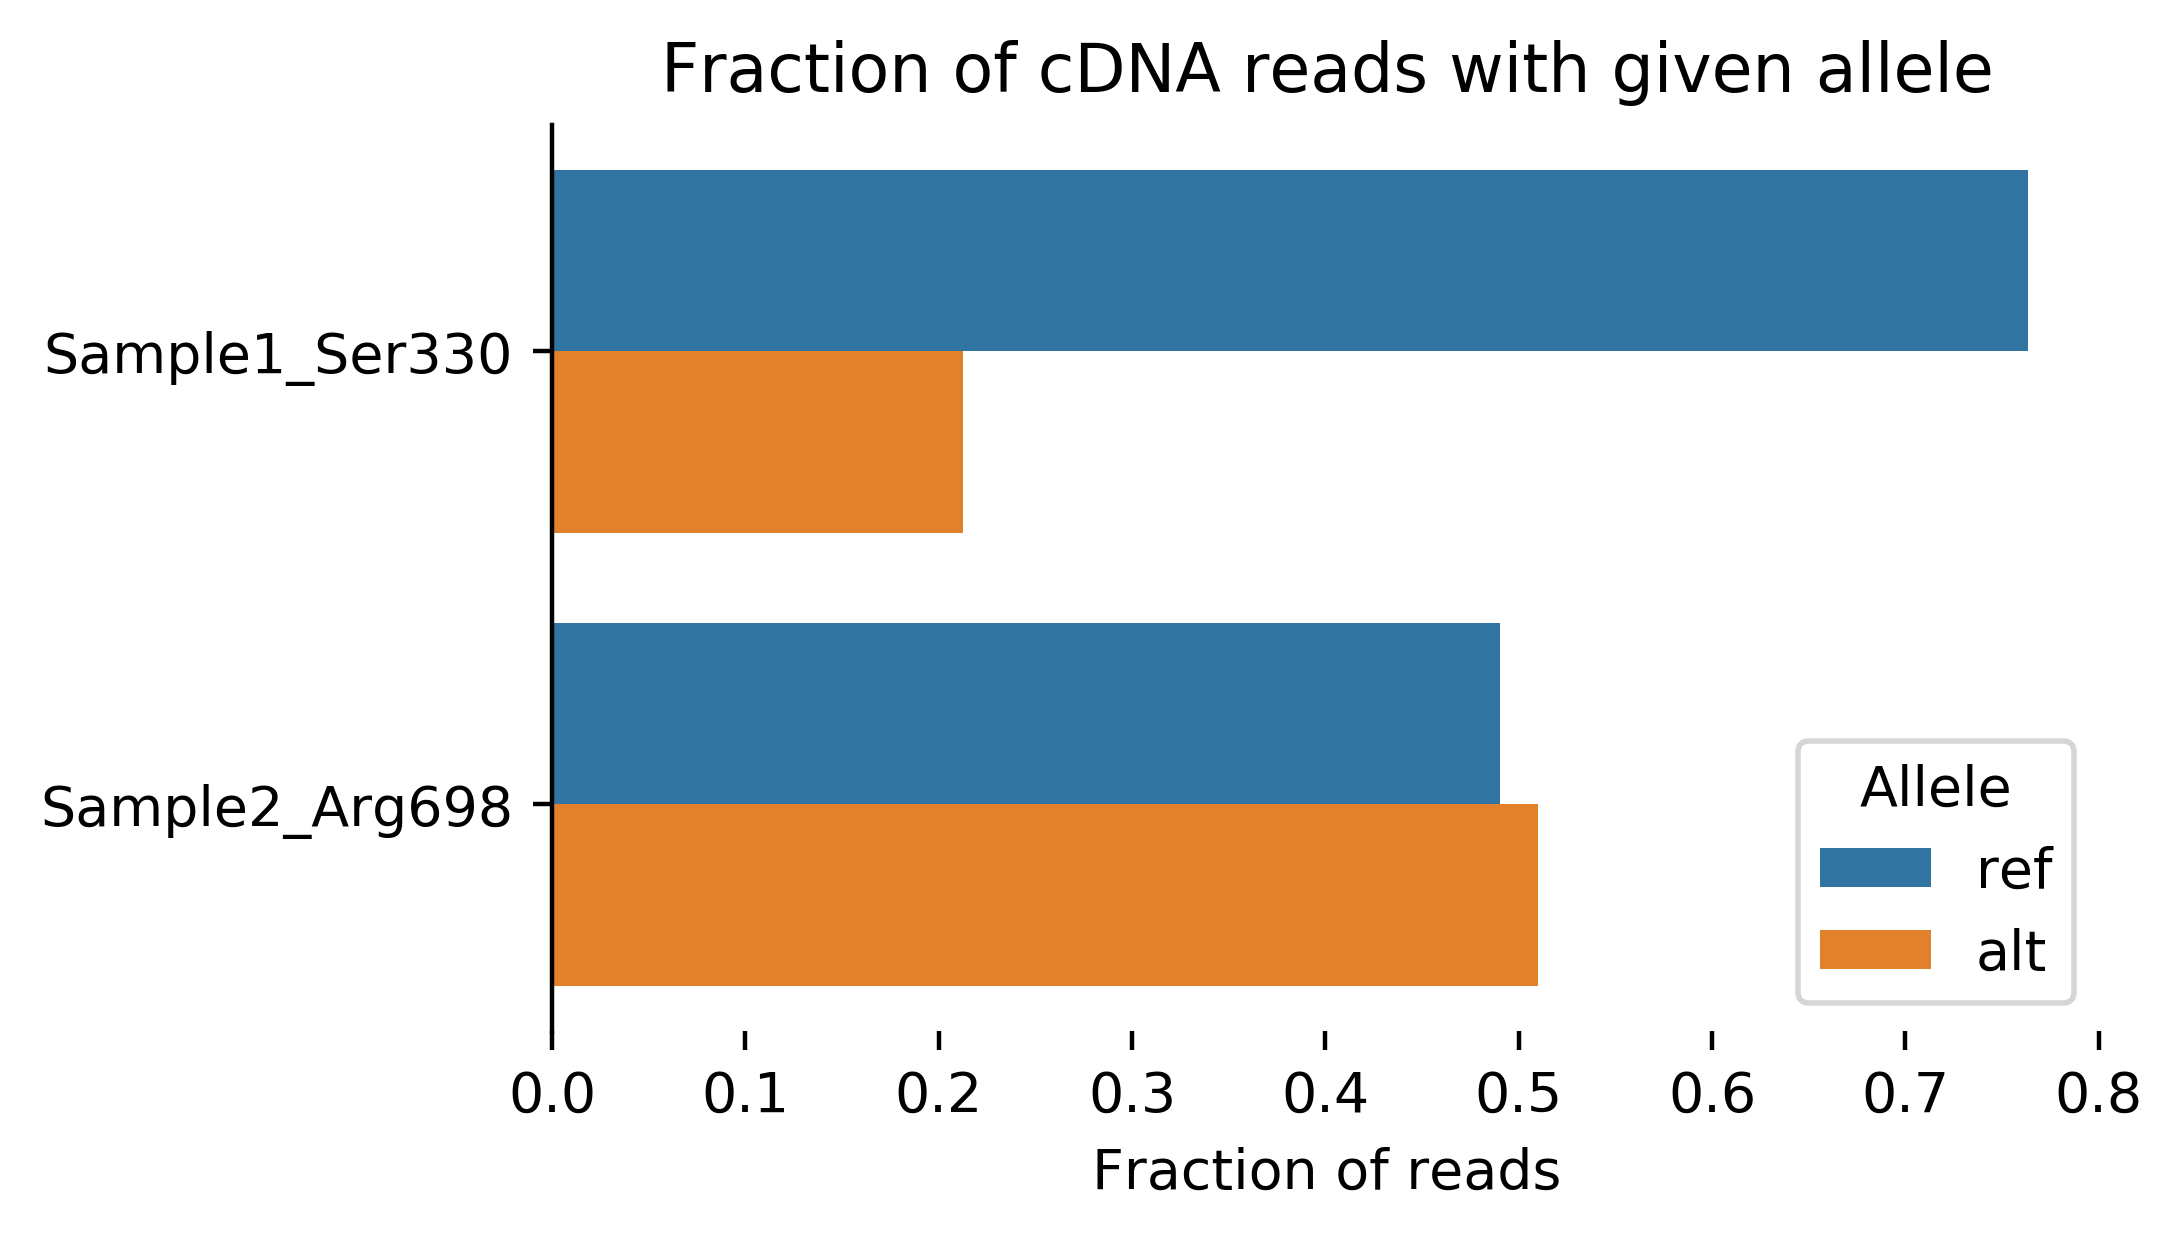

In [6]:
#high-res version of plot

plt.figure(figsize=(5, 3), dpi=400)
sns.barplot(
    data=d[ ['sample', 'snp_ref_hq_count_fraction', 'snp_alt_hq_count_fraction'] ] \
        .rename(columns = { 'snp_ref_hq_count_fraction': 'ref',  'snp_alt_hq_count_fraction': 'alt' }) \
        .melt(id_vars = ['sample'], var_name = 'Allele', value_name = 'fraction'),
    x='fraction',
    y='sample',
    hue='Allele',
    orient='h',
)
plt.title("Fraction of cDNA reads with given allele")
plt.xlabel("Fraction of reads")
plt.ylabel("")
sns.despine(bottom=True)